# Word2Vec model of yelp reviews: Yelp2Vec
In this notebook we will be exploring the gensim Word2Vec model trained on the yelp reviews.

In [1]:
import spacy
from gensim.models.word2vec import Word2Vec

from datetime import timedelta
from prep_text import checker
import pandas as pd
from umap import UMAP

import altair as alt
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

Lets load our model that was trained and implementated in train_word2vec.py.

In [2]:
yelp_2_vec = Word2Vec.load('data/models/word2vec/yelp2vec_epoch_0050/yelp2vec', mmap='r')

Now we will take a look at the parameters and stats for model training.

In [3]:
def inspect_model(word2vec_model:Word2Vec):
    """
    Displays trained gensim Word2Vec model stats/parameters
    """
    print('Word2Vec Model\n')
    print(f'Skipgram=1, CBOW=0                           : {word2vec_model.sg}')
    print(f'hierarchical softmax=1, negative sampeling=0 : {word2vec_model.hs}')
    print(f'Vector size                                  : {word2vec_model.vector_size}')
    print(f'Window Size                                  : {word2vec_model.window}')
    print(f'Training Epochs                              : {word2vec_model.epochs}')
    print(f'Total words in model                         : {word2vec_model.corpus_total_words:,}')
    print(f'Training Duration                            : {str(timedelta(seconds=word2vec_model.total_train_time))}')
    print(f'Corpus Sentence Count                        : {word2vec_model.corpus_count:,}')

In [4]:
inspect_model(yelp_2_vec)

Word2Vec Model

Skipgram=1, CBOW=0                           : 1
hierarchical softmax=1, negative sampeling=0 : 0
Vector size                                  : 200
Window Size                                  : 7
Training Epochs                              : 50
Total words in model                         : 506,348,667
Training Duration                            : 1 day, 5:04:58.011728
Corpus Sentence Count                        : 41,070,828


Extract the word vectors from the model

In [5]:
word_vectors = yelp_2_vec.wv

Using the word vectors we can get similar words. The similarity measure used here is the cosine similarity.

In [6]:
word_vectors.similarity('pasta', 'fettuccine')

0.8312346

In [7]:
word_vectors.most_similar(positive=['pasta'], topn=25)

[('fettuccine', 0.8312345743179321),
 ('penne', 0.8153570890426636),
 ('spaghetti', 0.8042887449264526),
 ('tortellini', 0.7979309558868408),
 ('linguini', 0.7978224754333496),
 ('linguine', 0.7941499948501587),
 ('alfredo', 0.7895228266716003),
 ('rigatoni', 0.7870948910713196),
 ('Pasta', 0.7769891023635864),
 ('fettucini', 0.7769865989685059),
 ('fettuccini', 0.7743735313415527),
 ('pasta-', 0.7696753144264221),
 ('lasagna', 0.7693284749984741),
 ('ravioli', 0.7637493014335632),
 ('fettucine', 0.7582417130470276),
 ('fusilli', 0.7508024573326111),
 ('ziti', 0.7472731471061707),
 ('bolognese', 0.744997501373291),
 ('penne_pasta', 0.7418925762176514),
 ('gnocchi', 0.7367632985115051),
 ('capellini', 0.7363892197608948),
 ('Alfredo', 0.7350318431854248),
 ('raviolis', 0.730956494808197),
 ('carbonara', 0.7254944443702698),
 ('manicotti', 0.7252016067504883)]

We can also do 'word algebra' to inspect relationships found by the model.

In [8]:
# breakfast + lunch
word_vectors.most_similar(positive=['breakfast', 'lunch'], topn=1)

[('brunch', 0.7639017105102539)]

In [9]:
# lunch + night - day
word_vectors.most_similar(positive=['lunch', 'night'], negative=['day'], topn=1)

[('dinner', 0.6542763113975525)]

In [10]:
# win + barley - grape
word_vectors.most_similar(positive=['wine', 'barley'], negative=['grape'], topn=1)

[('beer', 0.44774600863456726)]

In [11]:
# Taco_Bell + italian - mexican
word_vectors.most_similar(positive=["Taco_Bell", 'italian'], negative=['mexican'], topn=1)

[('Olive_Garden', 0.7133729457855225)]

Investigating which is more similar we can compare the similarity. here we can see that 'burger' is more similar to 'fry' than to 'bear'.

In [12]:
word_vectors.similarity('burger', 'beer'), word_vectors.similarity('burger', 'fry')

(0.31511444, 0.4736483)

We can also use the word vectors to find the word that doesnt match. again this uses the cosine similarity and picks the word with the smallest similarity to all the others. so if there are multiple words that dont match it will only find the one that matches the least.

In [13]:
word_list = ['pizza', 'cheese', 'pepperoni', 'candy']
word_vectors.doesnt_match(word_list)

'candy'

To extract the individual word vectors we can pass in a token or a token id. The returned vator can be the original vector or the L2 norm (Euclidean norm) of the vector.

In [14]:
word_vectors.get_vector('pizza', norm=True)

array([-0.02114177, -0.0422106 , -0.03016516, -0.04706495, -0.01442965,
        0.00068075, -0.05604038, -0.04465019,  0.22179139, -0.04554696,
        0.05393521, -0.02494087, -0.0481272 , -0.03895854, -0.05158949,
        0.11522041, -0.02166441, -0.080112  , -0.04725612, -0.01902329,
        0.07444087,  0.03620256, -0.01871352,  0.0718361 , -0.11070871,
       -0.04670068,  0.05094518,  0.01616112, -0.13214354,  0.00954147,
       -0.08037553,  0.00220729, -0.08519239, -0.05415861,  0.06550768,
        0.07282549, -0.01552948,  0.02856835, -0.05221891, -0.16291833,
       -0.04593122,  0.02169521,  0.00040815, -0.00088341,  0.122902  ,
       -0.09633536, -0.19214657, -0.04157423,  0.0289352 ,  0.15461913,
        0.03679696,  0.02592824,  0.02065636,  0.05697632, -0.03513681,
        0.03473445,  0.02697908,  0.02140136, -0.04346829,  0.18943958,
        0.00830103,  0.21878013, -0.04642973, -0.1091058 ,  0.07366887,
       -0.00466589, -0.08402806,  0.0826308 ,  0.08434464, -0.00

These vectors can be combined to represent a sentence/review as a vector. these vectors then can be used to for other downstream tasks such as sentament analysis, and other modeling tasks.

In this example we are pre-normalizing the vectors before they are combined so that one vector doesnt dominate the rest and skew the results.

In [15]:
review = "this restaurant was amazing great food great atmosphere terrible service".split()
review_vec = word_vectors.get_mean_vector(review, pre_normalize=True, post_normalize=False)
review_vec

array([ 4.03821990e-02, -1.70626212e-02,  6.49914071e-02,  3.10923159e-02,
        1.63572244e-02,  1.70936622e-02,  3.78421322e-02,  4.71289642e-02,
        1.25222830e-02,  2.77034696e-02, -1.35855302e-02, -5.00232866e-03,
       -4.18775901e-02,  2.65534259e-02,  9.46640968e-04,  5.25651984e-02,
       -5.52174337e-02, -9.28009488e-03, -1.53808771e-02, -2.97994521e-02,
        6.77069426e-02,  1.48833152e-02, -4.43245322e-02, -7.49395266e-02,
       -2.49233302e-02, -6.55144826e-02,  2.68785600e-02,  6.23728288e-03,
       -1.24787670e-02,  7.44656939e-03, -2.96286680e-02, -2.25087870e-02,
        9.07346047e-03, -1.77211761e-02, -5.74327484e-02,  5.41633442e-02,
        3.65464799e-02, -4.44129407e-02,  4.32824120e-02, -5.96379209e-03,
        9.47678275e-03, -2.39589922e-02, -4.97064143e-02, -3.10360007e-02,
        9.88811255e-03, -5.05662449e-02, -5.43732941e-02,  6.94947615e-02,
       -7.15141520e-02,  5.50507605e-02, -1.73576809e-02,  7.16341212e-02,
       -4.99388948e-02, -

The gensim implementation of Word2Vec has a simple way of extracting attributes associalted with the word vectors. in this case we are extracting the count of the word 'pizza' from our model.

In [16]:
word_vectors.get_vecattr('pizza', attr='count')

629072

## Visualization
Visualizing these word vectors requires that we reduce their dimensionality while maintaining the most amount of information. The first step is to extract the vectors in this case we will only extract the vectors that are not considered stopwords and have a minimum freequency in the corpus.

In [17]:
def get_sorted_vocab(word_vectors, min_count:int=1000, max_length:int|None=None, stopwords:list|set|None=None) -> list[tuple]:
    """retrieves the vocab from the word vectors with the freequency count sorted by freequency.

    Args:
        word_vectors (KeyedVectors): word vectors from a gensim Word2Vec model
        min_count (int, optional): minimum word freequency to include. Defaults to 1000.
        max_length (int | None, optional): max length of returned list if None no limit. Defaults to None.
        stopwords (list | set | None, optional): stopwords to exclude from the returned vocab list. Defaults to None.

    Returns:
        list[tuple(int, str, int)]: list of vocab word tuples sorted by freequency descending (index, word, freequency)
    """
    if stopwords is not None:
        stopwords_dict = {word:1 for word in stopwords}
    ordered_vocab = []
    for word, index in word_vectors.key_to_index.items():
        freequency = word_vectors.get_vecattr(word, attr='count')
        if freequency > min_count:
            if stopwords is not None:
                if not checker(word.lower(), stopwords_dict):
                    ordered_vocab.append((index, word, freequency))
                else:
                    continue
            else:
                ordered_vocab.append((index, word, freequency))

    ordered_vocab = sorted(ordered_vocab, key=lambda x: x[2], reverse=True)
    return ordered_vocab if max_length is None else ordered_vocab[:max_length]

In [18]:
stopwords = spacy.load('en_core_web_sm').Defaults.stop_words
top_words = get_sorted_vocab(word_vectors, min_count=100, max_length=None, stopwords=stopwords)

By implementing a minimum freequency of 100 we reduce the number of words from around 500 million words to 46044. We also extracted them sorted by freequence in descending order.

In [19]:
print(len(top_words))
top_words[:10]

46044


[(20, 'good', 3782585),
 (22, 'food', 3512044),
 (24, 'place', 2935198),
 (28, 'order', 2429772),
 (30, 'great', 2389655),
 (35, 'time', 1936714),
 (36, 'come', 1856544),
 (37, 'like', 1841913),
 (45, 'service', 1611041),
 (52, 'try', 1416024)]

We will then extract the normalized vectors themselves and add them to a dataframe with the words as the index.

In [20]:
def get_vector_frame(word_vectors, term_list:list[tuple], norm:bool=True) -> pd.DataFrame:
    """retrieves the word vectors of the terms in the terms list as a dataframe

    Args:
        word_vectors (KeyedVectors): word vectors from a gensim Word2Vec model
        term_list (list): list of terms as returned by get_sorted_vocab
        norm (bool, optional): whether to normalize the word vectors using the L2 Norm. Defaults to True.

    Returns:
        DataFrame: dataframe of the word vectors. with terms as the row index
    """
    terms = []
    vectors = []
    for term in term_list:
        word_vec = word_vectors.get_vector(term[1], norm=norm)
        terms.append(term[1])
        vectors.append(word_vec)

    term_frame = pd.DataFrame(vectors, index=terms)
    return term_frame

In [21]:
term_frame_normalized = get_vector_frame(word_vectors, top_words, norm=True)

In [22]:
term_frame_normalized.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
good,0.072509,0.018539,0.100976,0.036052,-0.065260,0.047782,0.029250,0.080569,0.072658,0.029203,...,0.128507,-0.038155,-0.066800,-0.106014,-0.021432,-0.011949,0.019734,0.008310,0.126471,0.016874
food,0.039938,-0.015412,0.145448,-0.051032,0.009102,0.037853,0.013427,0.076399,0.125767,0.023645,...,0.132657,0.016358,0.058525,0.023289,0.043192,-0.027990,-0.031817,0.089120,0.012455,0.124862
place,-0.026009,-0.030172,0.064160,0.020321,-0.012141,-0.057340,0.015676,0.053895,-0.033394,0.039854,...,0.116408,-0.112510,-0.013715,-0.144672,-0.063911,-0.149116,-0.043361,0.052830,0.077181,-0.076684
order,0.041106,-0.001781,0.173765,-0.008712,-0.063327,-0.004032,-0.082218,0.031371,0.007197,0.123813,...,-0.008360,-0.158455,0.041491,-0.050982,0.002410,0.026188,0.032116,0.015448,0.003396,0.043107
great,0.093681,0.022655,0.057541,0.095327,0.001712,-0.001233,0.011741,0.051611,0.007212,0.025115,...,0.146306,-0.046698,-0.036279,-0.051973,-0.050810,-0.152224,0.004316,0.133225,0.066593,0.039802


Here we use the Umap algorithm to reduce the dimensionality to 2. I chose Umap over TSNE or MDS as it is the best of both worlds i.e it preserved some global structure like MDS but also preserves local neighborhood structure like TSNE. Umap is also less finikey than TSNE which is very reactive to the choice of parameters.

In [23]:
# set the random stare for replicability, we also set the n_neighbors parameter to controle 
# the trade off between local structure and global structure. smaller values preserves local 
# structure and larger values preserves global structure
umap_vectors_normalized = UMAP(n_neighbors=10, random_state=42).fit_transform(term_frame_normalized)

Next we create a dataframe for the Umap vectors then add the words, and freequence counts.

In [24]:
umap_frame_normalized = pd.DataFrame(umap_vectors_normalized, index=term_frame_normalized.index).reset_index().rename({'index': 'word', 0: 'x', 1: 'y'}, axis=1)
umap_frame_normalized['freequency'] = [item[2] for item in top_words]

In [25]:
umap_frame_normalized.to_csv('data/umap_dataframe_norm.csv.gz')

# umap_frame_normalized = pd.read_csv('data/umap_dataframe_norm.csv.gz')

In [26]:
umap_frame_normalized.sample(10)

,word,x,y,freequency
39066,Fabio,-2.954031,-3.663169,128
10832,founder,5.995286,5.352543,850
45271,$_1.70,7.857762,12.685073,103
39241,knock_against,7.628196,7.117517,127
20844,El_Guero_Canelo,-0.971652,8.596132,324
37085,Pure_Fare,-1.792067,0.739916,138
17441,Moscato,0.862179,3.696084,421
16529,Jenn,-3.240202,-5.013381,454
24369,baja_fish_taco,-5.683192,6.412709,258
1,food,4.766557,8.480134,3512044


First lets plot the full Umap projections. we will be able to see the general structure of the word vectors.

Text(0, 0.5, '')

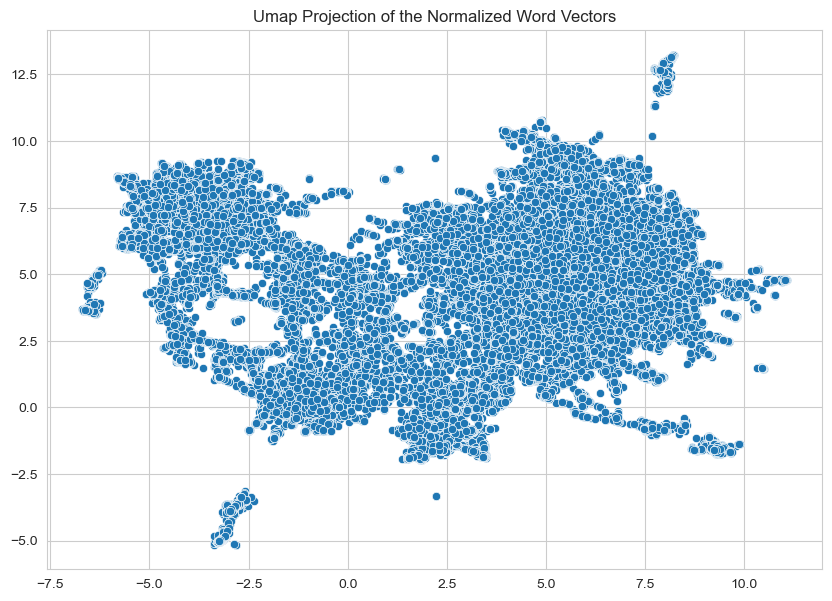

In [27]:
fig, ax = plt.subplots(figsize=(10, 7))
sns.scatterplot(data=umap_frame_normalized, x='x', y='y', ax=ax)
ax.set_title('Umap Projection of the Normalized Word Vectors'),
ax.set_xlabel('')
ax.set_ylabel('')

This is nice but we want to be able to inspect the clusters formed as the overall structure doesnt tell us much. for that we will use altair. the main draw back about altair is that it can only hande a max of 5000 data points. Because the Umap projection dataframe is still sorted by descending freequency we will just take the first 5000 rows.

In [28]:
def plot_umap_vectors(plot_frame:pd.DataFrame, title:str) -> alt.Chart:
    """builds an altair Chart of the dataframe

    Args:
        plot_frame (DataFrame): dataframe, columns must be [word, x, y, freequency]
        title (str): the title of the plot

    Returns:
        alt.Chart: the altair Chart
    """
    # altair can only hadle 5000 data points
    plot_frame = plot_frame.iloc[:5000, :]
    
    umap_plot = alt.Chart(plot_frame).mark_circle(fillOpacity=.6).encode(
        x=alt.X('x', title=None),
        y=alt.Y('y', title=None),
        tooltip=[alt.Tooltip('word', title='Word'), alt.Tooltip('freequency', title='Freequency')]
    ).properties(
        title=alt.TitleParams(
            title,
            subtitle='Top 5000 most freequent words',
            fontSize=20
            ),
        height=500,
        width=800
    ).interactive()


    return umap_plot

In [29]:
normalized = plot_umap_vectors(umap_frame_normalized, 'Umap Projection of the Normalized Word Vectors')

normalized

/Users/alexanderlevin-koopman/opt/anaconda3/envs/topic_analysis/lib/python3.10/site-packages/altair/utils/core.py:283: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)

We can still see the overall structure but can now hover over the individual data points and inspect the word associated with that vector and the freequency. On the left of the plot we can see the it contains mainly ingredients and they are grouped with similar words (breakfast items are grouped together).